In [17]:
import numpy as np
import scipy.integrate

In [18]:
import scipy.optimize

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
def u(x, u_max):
    ''' Control function
    
    Parameters
    ----------
    
    x : scalar
        Psi3 value.
        
    u_max : scalar 
            Maximum absolute control function value
            
    Returns
    ----------
    ux : scalar
         Control function value at given x with respect to u_max.
    '''
    
    ux = 0.0
    
    if x <= -1:
        ux = -u_max
    elif x > 1:
        ux = u_max
        
    return ux

In [5]:
def ode(t, x, args):
    ''' Right hand side of ODE
    
    Parameters
    ----------
    t : scalar
        Time.
        
    x : array_like with 5 components
        State vector.
        
    *args : array_like with 4 components
            args[0] - C1
            args[1] - C2
            args[2] - u_max
         
    Returns
    -------
    
    ds : np.array
        First order derivative
    '''
#     print(x)
#     print(args)
    x1, x2, x3, x4, x5 = x
    dx1dt = x2
    dx2dt = -args[0]*np.sin(2.0*x1)+args[1]*u(x3, args[2])
    dx3dt = -x4
    dx4dt = 2.0*args[0]*x3*np.cos(2.0*x1)
    dx5dt = -np.abs(u(x3, args[2]))
    
    dx = np.array([dx1dt, dx2dt, dx3dt, dx4dt, dx5dt])
    
    return dx

In [6]:
def stopNull(t, x, lst, **kwargs):
    ''' Dummy function for scipy.integrate.ode solout application. \
        Can be used for gathering all intergation steps.
        Shoudn't be called directly but through scipy.integrate.ode.
    
    Parameters
    ----------

    t : scalar
        Time.
        
    s : array_like with 6 components
        State vector.

    lst : list
        Every call of this function put np.hstack of (s, t) into lst. 
                      
    Returns
    -------
    
    0 : scalar
        Always. Will be treated by scipy.integrate.ode as it shouldn't
        stop integration process.
          
    '''
    lst.append(np.hstack((t,x)))
    return 0

In [16]:
def propOde(x0, tspan, C1, C2, u_max, **kwargs):
    ''' Propagate systwm of ode.
    Uses scipy.integrate.ode with 'dopri5' integrator.
    
    Parameters
    ----------
 
    x0 : array_like with 5 components
        Initial state vector.
        
    tspan : array_like with 2 components
        Initial and end time.
        
    C1 : scalar
         C1 parameter for ODE.
         
    C2 : scalar
         C2 parameter for ODE.
    
    u_max : scalar
            u_max parameter for ODE.
        
        
    Optional
    --------
    
    solout_func : function
                  Solout function for integrator.
        
    integrator : str
                 Name of the integrator.
        
    Returns
    -------
    
    Xt : np.array
      Array of (n,6) shape of state vectors and times
      for each integrator step (t, x1, x2, x3, x4, x5).
    '''
    #import pdb; pdb.set_trace()
    prop = scipy.integrate.ode(ode)
    if 'integrator' in kwargs:
        integrator = kwargs['integrator']
        prop.set_integrator(integrator)
    else:
        prop.set_integrator('dopri5')
        
    prop.set_initial_value(x0, tspan[0])
    
    prop.set_f_params([C1, C2, u_max])
    
    lst = []
    
    if 'solout_func' in kwargs:
        solout_func = kwargs['solout_func']
        prop.set_solout(solout_func)
    else:
        prop.set_solout(lambda t, s: stopNull(t, s, lst))
        
    prop.integrate(tspan[1])
    
    del prop
    
    return np.asarray(lst)

In [8]:
#U_max = 5
#C1 = 0.0430400628
#C2 = 1.0
# g = 12*1e4

In [8]:
def get_initial_state(x1T, x2T, g1 , g2):
    x1 = x1T
    x2 = x2T
    x3 = -2.0*g2*x2T
    x4 = -2.0*g1*x1T
    x5 = g1*x1T**2 + g2*x2T**2
    return np.array([x1, x2, x3, x4, x5])

In [9]:
#t0 0 
#T 10

In [10]:
s0 = get_initial_state(0.001, 0.0005, 12*1e4, 12*1e4)

In [11]:
s0

array([ 1.0e-03,  5.0e-04, -1.2e+02, -2.4e+02,  1.5e-01])

In [12]:
def create_arc(c,r,a1,a2,s):
    alpha = np.radians(np.linspace(a1,a2,s))
    x = r*np.cos(alpha) + c[0]
    y = r*np.sin(alpha) + c[1]
    
    return np.hstack((x.reshape(-1,1),y.reshape(-1,1)) )

In [13]:
stp = create_arc([0,0],0.001,0,360,30)

<IPython.core.display.Javascript object>


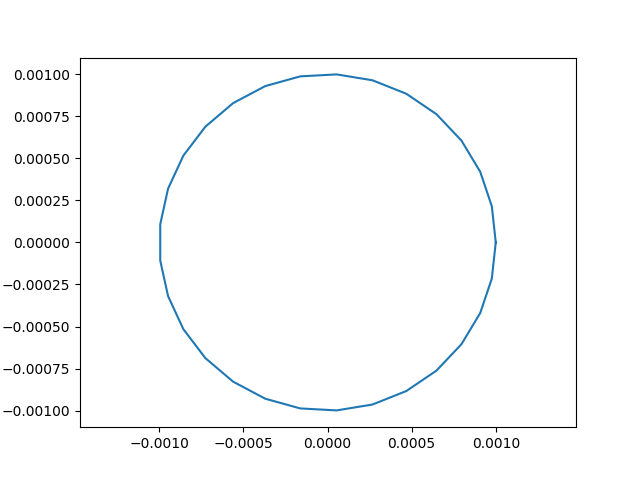

(-0.0010938448550120777,
 0.001099706897857718,
 -0.0010983867552362362,
 0.0010983867552362362)

In [14]:
plt.plot(stp[:,0],stp[:,1])
plt.axis('equal')

In [15]:
sols = []
for point in stp:
    s0 = get_initial_state(*point, 12*1e5, 12*1e5)
    sols.append(propOde(s0, [5.0, 0.0], C1=0.0430400628, C2=1.0, u_max=5.0))

AttributeError: module 'scipy' has no attribute 'integrate'

<IPython.core.display.Javascript object>


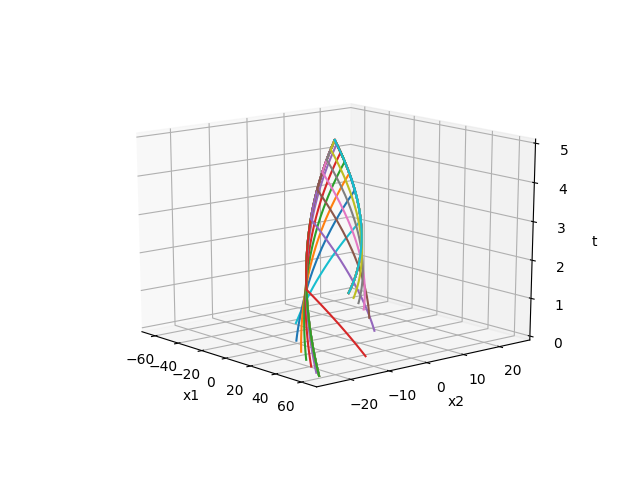

Text(0.5, 0, 't')

In [17]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for traject in sols:
    ax.plot(traject[:,1], traject[:,2], traject[:,0])
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('t')

In [54]:
c1, a1, b1 = (0.5, 0.3, 0.2)

In [57]:
def find_intersection(point, curv_coef):
    def func(x, args):
        c, a, b = args
        return b*(x-a)/a + b - np.sign(b)*c*np.cos(x)
    c = curv_coef
    a, b = point
    x1 = scipy.optimize.root(func, a, [c, a, b], tol=1e-16)['x']
    x2 = b*(x1-a)/a + b
    return np.array([x1, x2])

In [58]:
sol1 = find_intersection([a1, b1], c1)

<IPython.core.display.Javascript object>


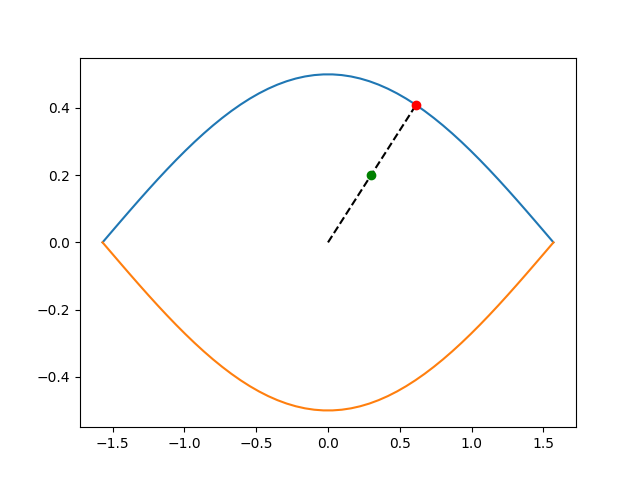

In [59]:
xspan = np.linspace(-np.pi/2, np.pi/2)
plt.plot(xspan, c1*np.cos(xspan))
plt.plot(xspan, -c1*np.cos(xspan))
plt.plot([0.0, sol1[0]], [0.0, sol1[1]], 'k--')
plt.plot(a1, b1, 'go')
plt.plot(*sol1, 'ro')